In [1]:
import numpy as np
from scipy.integrate import fixed_quad
import plotly.graph_objects as go
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import time
import os 
import matplotlib.pyplot as plt

In [2]:
# Carrega os dados experimentais
dat = pd.read_csv('data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)

x_values = []
y_values = []
y_error_values = []


#totem
# Define os blocos de dados
data_blocks = [
    (0, 65),   # dsig 7000 (linhas 0-28)
    (65, 118),  # dsig 8000 (linhas 29-57)
    (118, None) # dsig 13000 (linhas 58 até final)
]


#atlas
# data_blocks = [
#     (0, 29),   # dsig 7000 (linhas 0-28)
#     (29, 58),  # dsig 8000 (linhas 29-57)
#     (58, None) # dsig 13000 (linhas 58 até final)
# ]

for start, end in data_blocks:
    if end is not None:
        df = dat.iloc[start:end]
    else:
        df = dat.iloc[start:]
    
    x_values.append(df[0].to_numpy())
    y_values.append(df[1].to_numpy())
    y_error_values.append(df[2].to_numpy())

# Organiza os dados por energia
x_7000, y_7000, y_error_7000 = x_values[0], y_values[0], y_error_values[0]
x_8000, y_8000, y_error_8000 = x_values[1], y_values[1], y_error_values[1]
x_13000, y_13000, y_error_13000 = x_values[2], y_values[2], y_error_values[2]


/tmp/ipykernel_23570/526549398.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dat = pd.read_csv('data/ens_totem_difc0_2.dat', delim_whitespace=True, header=None)


In [3]:
n_points = 10000

b_0 = (33 - 6) / (12 * np.pi)
Lambda = 0.284  # ΛQCD em GeV
gamma_1 = 0.084
gamma_2 = 2.36
rho = 4.0
s0 = 1.0
alpha_prime = 0.25


# Valores iniciais dos parâmetros
#log totem
# initial_params = {
#     'epsilon_totem': 0.0892,
#     'mg_log_totem': 0.380,
#     'a1_log_totem': 1.491,
#     'a2_log_totem': 2.77
# }

#log atlas, ignora o nome das variaveis 
# initial_params = {
#     'epsilon_totem': 0.0753,
#     'mg_log_totem': 0.356,
#     'a1_log_totem': 1.373,
#     'a2_log_totem': 2.50
# }

#pl totem
initial_params = {
    'epsilon_totem': 0.0892,
    'mg_log_totem': 0.447,
    'a1_log_totem': 1.689,
    'a2_log_totem': 1.7
}

#pl atlas
# initial_params = {
#     'epsilon_totem': 0.0753,
#     'mg_log_totem': 0.421,
#     'a1_log_totem': 1.517,
#     'a2_log_totem': 2.05
# }

# Variação de ±2% para os valores iniciais usando key, value (dict) 
initial_params_low = {k: v * 0.70 for k, v in initial_params.items()}
initial_params_high = {k: v * 1.3 for k, v in initial_params.items()}


In [4]:
# def m2_log(q2, mg):

#     lambda_squared = Lambda ** 2
#     rho_mg_squared = rho * mg ** 2
#     ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)

#     return mg ** 2 * ratio ** (-1 - gamma_1)

def m2_log(q2, mg):

    lambda_squared = Lambda ** 2
    rho_mg_squared = rho * mg ** 2
    ratio = np.log((q2 + rho_mg_squared) / lambda_squared) / np.log(rho_mg_squared / lambda_squared)

    return (mg ** 4 / (q2 + mg ** 2)) * ratio ** (gamma_2 - 1)

def G_p(q2, a1, a2):
    return np.exp(-(a1 * q2 + a2 * q2 ** 2))

def alpha_D(q2, mg, m2_func):
    m2 = m2_func(q2, mg)
    return 1.0 / (b_0 * (q2 + m2) * np.log((q2 + 4 * m2) / (Lambda ** 2)))

def T_1(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    G0 = G_p(q2, a1, a2)
    return alpha_D_plus * alpha_D_minus * G0 ** 2

def T_2(k, q, phi, mg, a1, a2, m2_func):
    q2 = q 
    qk_cos = np.sqrt(q) * k * np.cos(phi)
    qk_plus_squared = q2 / 4 + qk_cos + k ** 2
    qk_minus_squared = q2 / 4 - qk_cos + k ** 2
    alpha_D_plus = alpha_D(qk_plus_squared, mg, m2_func)
    alpha_D_minus = alpha_D(qk_minus_squared, mg, m2_func)
    factor = q2 + 9 * abs(k ** 2 - q2 / 4)
    G0 = G_p(q2, a1, a2)
    G_minus = G_p(factor, a1, a2)
    return alpha_D_plus * alpha_D_minus * G_minus * (2 * G0 - G_minus)

def integrand(y, x, mg, a1, a2, m2_func, q_val, sqrt_s):
    k = sqrt_s * x 
    phi = 2 * np.pi * y
    jacobian = 2 * np.pi * sqrt_s 
    return k * (T_1(k, q_val, phi, mg, a1, a2, m2_func) - T_2(k, q_val, phi, mg, a1, a2, m2_func)) * jacobian 

def amp_calculation(diff_T, s, epsilon, t):
    alpha_pomeron = 1.0 + epsilon + alpha_prime * t
    regge_factor = (s**alpha_pomeron) * 1/(s0**(alpha_pomeron-1))
    return 1j * 8 * regge_factor * diff_T  

def differential_sigma(amp_value, s):
    amp_squared = amp_value.imag * amp_value.imag
    denominator = (16 * np.pi * s**2)
    return amp_squared / denominator * 0.389379323

In [5]:
def model_function(x, eps, mg, a1, a2, sqrt_s):

    # taking arguments for functions 
    params = {
        'epsilon_totem': eps,
        'mg_log_totem': mg,
        'a1_log_totem': a1,
        'a2_log_totem': a2
    }
    
    dif_sigma_lst = []
    
    for q2 in x:
        t = -q2
        
        def inner_integral(x_inner):
            return fixed_quad(
                lambda y: integrand(y, x_inner, params['mg_log_totem'], params['a1_log_totem'], 
                                  params['a2_log_totem'], m2_log, q2, sqrt_s),
                0, 1,
                n=n_points
            )[0]

        integral_value = fixed_quad(
            inner_integral,
            0, 1,
            n=n_points
        )[0]

        diff_T = integral_value
        s = sqrt_s ** 2
        amp_value = amp_calculation(diff_T, s, params['epsilon_totem'], t)
        dif_sigma_value = differential_sigma(amp_value, s)
        dif_sigma_lst.append(dif_sigma_value)
    
    return np.array(dif_sigma_lst)

In [6]:
# === Criação dos Objetos LeastSquares para Cada Energia ===
# Para 7 TeV
lsq_7000 = LeastSquares(x_7000, y_7000, y_error_7000, 
                       lambda x, eps, mg, a1, a2: model_function(x, eps, mg, a1, a2, 7000))

# Para 8 TeV
lsq_8000 = LeastSquares(x_8000, y_8000, y_error_8000, 
                       lambda x, eps, mg, a1, a2: model_function(x, eps, mg, a1, a2, 8000))

# Para 13 TeV
lsq_13000 = LeastSquares(x_13000, y_13000, y_error_13000, 
                        lambda x, eps, mg, a1, a2: model_function(x, eps, mg, a1, a2, 13000))

# Combina os custos
total_cost = lsq_7000 + lsq_8000 + lsq_13000

In [7]:
# Cria o objeto Minuit com o custo combinado
m = Minuit(total_cost, 
           eps=initial_params['epsilon_totem'],
           mg=initial_params['mg_log_totem'],
           a1=initial_params['a1_log_totem'],
           a2=initial_params['a2_log_totem'])

# Configura os limites iniciais (±2% dos valores iniciais)
m.limits['eps'] = (initial_params_low['epsilon_totem'], initial_params_high['epsilon_totem'])
m.limits['mg'] = (initial_params_low['mg_log_totem'], initial_params_high['mg_log_totem'])
m.limits['a1'] = (initial_params_low['a1_log_totem'], initial_params_high['a1_log_totem'])
m.limits['a2'] = (initial_params_low['a2_log_totem'], initial_params_high['a2_log_totem'])

# Configurações adicionais
m.errordef = 1
m.tol = 1

max_attempts = 10  # Número máximo de tentativas
initial_percentage = 0.02  # Começa com 2%
max_percentage = 0.50  # Limite máximo de expansão (50%)
current_percentage = initial_percentage

for attempt in range(max_attempts):
    m.migrad()
    
    # Verifica se há parâmetros nos limites
    params_at_limit = []
    for param in ['eps', 'mg', 'a1', 'a2']:
        value = m.values[param]
        lower, upper = m.limits[param]
        
        # Verifica se o valor está próximo do limite (com tolerância relativa)
        tol = 1e-4 * (upper - lower)  # Tolerância relativa
        if abs(value - lower) < tol or abs(value - upper) < tol:
            params_at_limit.append(param)
    
    # Se não há parâmetros nos limites, sai do loop
    if not params_at_limit:
        print("Minimização convergiu sem parâmetros nos limites!")
        break
        
    print(f"Tentativa {attempt + 1}: Parâmetros nos limites - {params_at_limit}")
    print(f"Ajustando limites em {current_percentage*100:.1f}%")
    
    # Ajusta os limites para os parâmetros problemáticos
    for param in params_at_limit:
        lower, upper = m.limits[param]
        current_range = upper - lower
        
        # Expande os limites
        expansion = current_percentage * current_range
        new_lower = lower - expansion
        new_upper = upper + expansion
        
        # Atualiza os limites
        m.limits[param] = (new_lower, new_upper)
    
    # Aumenta a porcentagem para a próxima tentativa
    current_percentage = min(current_percentage * 1.5, max_percentage)
    
    # Se for a última tentativa, mostra mensagem de aviso
    if attempt == max_attempts - 1:
        print(f"Atenção: Atingiu o número máximo de tentativas ({max_attempts})")

# Se convergiu, prossegue com hesse e minos
if m.fmin.is_valid:
    print("\nResultado final válido!")
    print("Parâmetros finais:")
    for param in ['eps', 'mg', 'a1', 'a2']:
        lower, upper = m.limits[param]
        print(f"{param}: {m.values[param]:.6f} (limites: {lower:.6f} - {upper:.6f})")
    
    m.hesse()
    m.minos(cl=0.9)
    # Opcional: rodar migrad novamente após hesse/minos
    m.migrad()
else:
    print("\nMinimização não convergiu após ajustes")

/home/victorli/miniconda3/lib/python3.12/site-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


Tentativa 1: Parâmetros nos limites - ['a2']
Ajustando limites em 2.0%
Tentativa 2: Parâmetros nos limites - ['a2']
Ajustando limites em 3.0%
Tentativa 3: Parâmetros nos limites - ['a2']
Ajustando limites em 4.5%
Tentativa 4: Parâmetros nos limites - ['a2']
Ajustando limites em 6.8%
Tentativa 5: Parâmetros nos limites - ['a2']
Ajustando limites em 10.1%
Tentativa 6: Parâmetros nos limites - ['a2']
Ajustando limites em 15.2%
Tentativa 7: Parâmetros nos limites - ['a2']
Ajustando limites em 22.8%
Minimização convergiu sem parâmetros nos limites!

Resultado final válido!
Parâmetros finais:
eps: 0.077579 (limites: 0.062440 - 0.115960)
mg: 0.423821 (limites: 0.312900 - 0.581100)
a1: 1.454662 (limites: 1.182300 - 2.195700)
a2: 2.930190 (limites: 0.112694 - 3.287306)


In [8]:
print(m.limits)
print(m.values)


<LimitView eps=(0.062439999999999996, 0.11596000000000001) mg=(0.3129, 0.5811000000000001) a1=(1.1823, 2.1957) a2=(0.11269401971067661, 3.287305980289324)>
<ValueView eps=0.07753868540091415 mg=0.423723005138613 a1=1.4542697497170902 a2=2.9313583907273846>


In [9]:
print(m.fmin)
chi2_total = m.fval
print(f"Chi-quadrado total: {chi2_total:.2f}")

ndof = m.ndof
print(f"Graus de liberdade: {ndof}")

chi2_per_dof = chi2_total / ndof
print(f"Chi-quadrado por grau de liberdade: {chi2_per_dof:.2f}")


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 150.1 (χ²/ndof = 0.5)      │             Nfcn = 3352              │
│ EDM = 3.54e-06 (Goal: 0.002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
Chi-quadrado total: 150.13
Graus de liberdade: 328.0
Chi-quadrado por grau de liberdade:

In [10]:
print("\nResultados da otimização:")
print(m)

# Parâmetros otimizados com mapeamento para os nomes originais
optimized_params = {
    'epsilon_totem': m.values['eps'],
    'mg_log_totem': m.values['mg'],
    'a1_log_totem': m.values['a1'],
    'a2_log_totem': m.values['a2']
}

print("\nParâmetros otimizados:")
for name, value in optimized_params.items():
    print(f"{name}: {value:.6f}")



Resultados da otimização:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 150.1 (χ²/ndof = 0.5)      │             Nfcn = 3352              │
│ EDM = 3.54e-06 (Goal: 0.002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────

In [11]:
# === Cálculo do Modelo com Parâmetros Otimizados ===
print("\nCalculando modelo com parâmetros otimizados...")



def calculate_model(params, sqrt_s_values, x_values_dict):
    model_results = {}
    for sqrt_s in sqrt_s_values:
        x = x_values_dict[sqrt_s]
        model_results[sqrt_s] = model_function(x, params['epsilon_totem'], 
                                             params['mg_log_totem'], 
                                             params['a1_log_totem'], 
                                             params['a2_log_totem'], 
                                             sqrt_s)
    return model_results

# Calcula os valores do modelo
x_values_dict = {7000: x_7000, 8000: x_8000, 13000: x_13000}
model_results = calculate_model(optimized_params, [7000, 8000, 13000], x_values_dict)





Calculando modelo com parâmetros otimizados...


In [12]:
# print("\nGerando gráficos...")

# fig = go.Figure()

# # Adiciona os dados experimentais
# fig.add_trace(go.Scatter(
#     x=x_7000, y=y_7000, error_y=dict(type='data', array=y_error_7000, visible=True),
#     mode='markers', name='Dados 7 TeV', marker=dict(color='black', size=6)
# ))

# fig.add_trace(go.Scatter(
#     x=x_8000, y=y_8000*10, error_y=dict(type='data', array=y_error_8000*10, visible=True),
#     mode='markers', name='Dados 8 TeV ×10', marker=dict(color='black', size=6)
# ))

# fig.add_trace(go.Scatter(
#     x=x_13000, y=y_13000*100, error_y=dict(type='data', array=y_error_13000*100, visible=True),
#     mode='markers', name='Dados 13 TeV ×100', marker=dict(color='black', size=6)
# ))

# # Adiciona as curvas do modelo otimizado
# fig.add_trace(go.Scatter(
#     x=x_7000, y=model_results[7000],
#     mode='lines', name='Modelo 7 TeV', line=dict(color='blue', width=2)
# ))

# fig.add_trace(go.Scatter(
#     x=x_8000, y=model_results[8000]*10,
#     mode='lines', name='Modelo 8 TeV ×10', line=dict(color='red', width=2)
# ))

# fig.add_trace(go.Scatter(
#     x=x_13000, y=model_results[13000]*100,
#     mode='lines', name='Modelo 13 TeV ×100', line=dict(color='green', width=2)
# ))

# fig.update_layout(
#     title='Ajuste do Modelo TOTEM com massa logarítmica',
#     xaxis_title='|t| (GeV²)',
#     yaxis_title='dσ/dt (mb/GeV²)',
#     yaxis_type='log',
#     showlegend=True
# )

# if not os.path.exists('plots'):
#     os.makedirs('plots', exist_ok=True)

# fig.write_image("plots/totem_fit_optimized.pdf", width=1400, height=600, scale=2)

# fig.show()


Gerando gráficos...


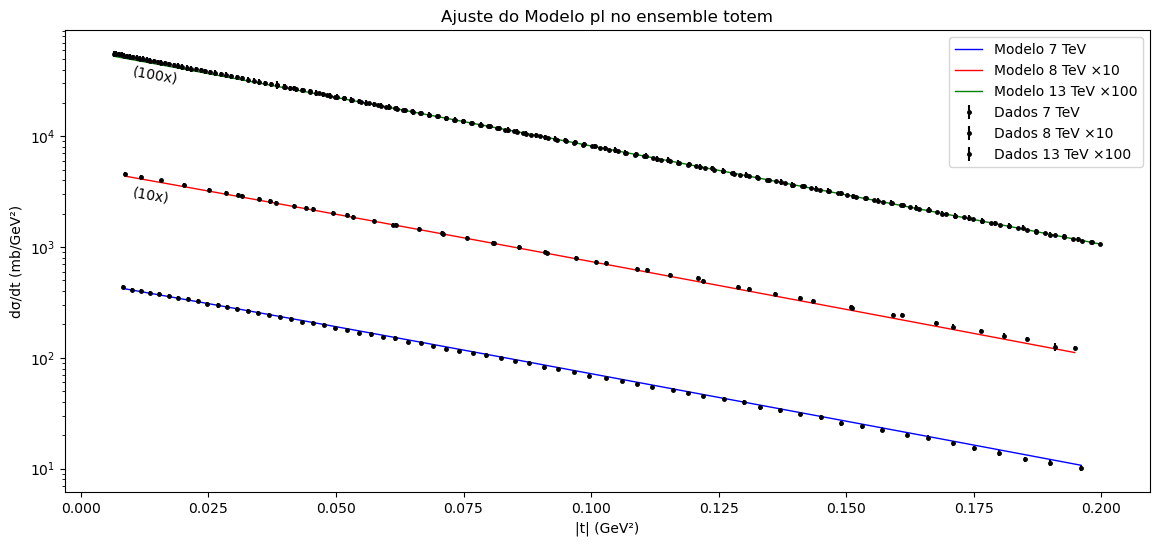

In [13]:
print("\nGerando gráficos...")

model = 'pl'
ensemble = 'totem'

plt.figure(figsize=(14, 6))

# Adiciona os dados experimentais com barras de erro
plt.errorbar(x_7000, y_7000, yerr=y_error_7000, 
             fmt='o', color='black', markersize=2.5, label='Dados 7 TeV')
plt.errorbar(x_8000, y_8000*10, yerr=y_error_8000*10, 
             fmt='o', color='black', markersize=2.5, label='Dados 8 TeV ×10')
plt.errorbar(x_13000, y_13000*100, yerr=y_error_13000*100, 
             fmt='o', color='black', markersize=2.5, label='Dados 13 TeV ×100')

# Adiciona as curvas do modelo otimizado
plt.plot(x_7000, model_results[7000], 
         '-', color='blue', linewidth=1, label='Modelo 7 TeV')
plt.plot(x_8000, model_results[8000]*10, 
         '-', color='red', linewidth=1, label='Modelo 8 TeV ×10')
plt.plot(x_13000, model_results[13000]*100, 
         '-', color='green', linewidth=1, label='Modelo 13 TeV ×100')

# Configurações do gráfico
plt.title(f'Ajuste do Modelo {model} no ensemble {ensemble}')
plt.text(0.01, 10**3+1500, '(10x)', rotation=350)
plt.text(0.01, 10**4+20000, '(100x)', rotation=350)
plt.xlabel('|t| (GeV²)')
plt.ylabel('dσ/dt (mb/GeV²)')
plt.yscale('log')
plt.legend()

# Cria o diretório se não existir
if not os.path.exists('plots'):
    os.makedirs('plots', exist_ok=True)

# Salva a figura
plt.savefig(f"plots/fit_optimized_{model}_{ensemble}.pdf", bbox_inches='tight', dpi=1200)
plt.show()